# Predicting Credit Default.
#### Identifying risky credit patterns

We'll be analyzing credit card data, collected in Taiwan (link below). Trying to predict patterns that lead to defaulting on credit. Various Machine Learning methods will be applied to the dataset. We will also try to derive some features to help our predictions. The 'real world' applications of these methods will be considered throughout our report. Balancing accuracy and the rate of true positive predictions will be the main consideration throughout the report. 

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

Authors -
Kyle Hayes, 
Donald Dong, 
Kellen Rice

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=UndefinedMetricWarning)

### Definitions:
**Default:** After you’ve failed to make a payment on your credit card for 180 days, your issuer assumes you’re probably never going to. At this point, the issuer can (and usually does) close your card, write off what you owe as bad debt and sell your account to a collections agency.

In [3]:
df = pd.read_csv("default_cc_train.csv", sep=',')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,8811,390000,2,1,1,64,1,-2,-2,-2,...,0,0,8668,0,0,0,0,8668,4490,1
1,23496,60000,2,2,2,31,0,0,0,2,...,42057,26877,26493,4100,4073,0,1600,0,1100,1
2,1164,210000,2,2,1,39,0,0,0,0,...,19850,15530,13021,14000,3007,5000,1000,13021,22171,0
3,19421,500000,2,1,1,35,-2,-1,0,-1,...,7896,8970,215305,36277,6112,10014,9018,215518,20018,0
4,16890,150000,1,1,2,37,2,2,2,2,...,38687,37765,40352,1600,0,3300,0,3200,1700,1


Interesting to note, that as these data were collected in Taiwan, the monetary amounts are all in Tawianese New Dollars. Current conversion rate is approximately 30 TWD to 1 USD.

Text(0.5,1,'Correlation of features')

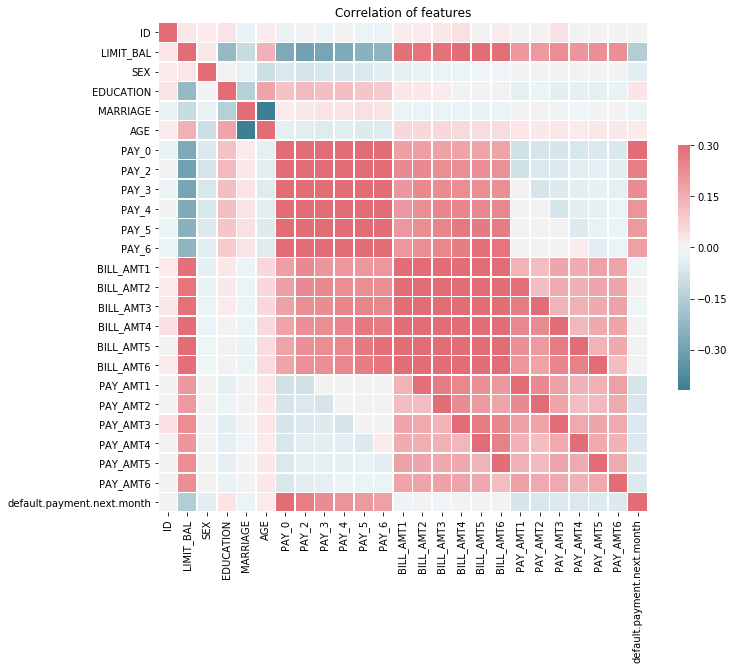

In [4]:
corr = df.corr()
mask = np.zeros_like(corr,dtype=np.bool)
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True,
            linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation of features')

Based on the correlation plot we can see that the features most strongly linked with default status are the payment fields. The payment field is categorical, despite having numeric placeholders. The assumption here would be that a higher values (indicating late payments) would correlate very highly with ones likelihood of defaulting on their balance. 

In [5]:
df.info()
print("Shape: ",df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 25 columns):
ID                            25000 non-null int64
LIMIT_BAL                     25000 non-null int64
SEX                           25000 non-null int64
EDUCATION                     25000 non-null int64
MARRIAGE                      25000 non-null int64
AGE                           25000 non-null int64
PAY_0                         25000 non-null int64
PAY_2                         25000 non-null int64
PAY_3                         25000 non-null int64
PAY_4                         25000 non-null int64
PAY_5                         25000 non-null int64
PAY_6                         25000 non-null int64
BILL_AMT1                     25000 non-null int64
BILL_AMT2                     25000 non-null int64
BILL_AMT3                     25000 non-null int64
BILL_AMT4                     25000 non-null int64
BILL_AMT5                     25000 non-null int64
BILL_AMT6               

Looks like its a full 25000 rows with no null values. Does not look like any data cleaning will be needed only scaling and preprocessing.

Text(0.5,0,'Default payments')

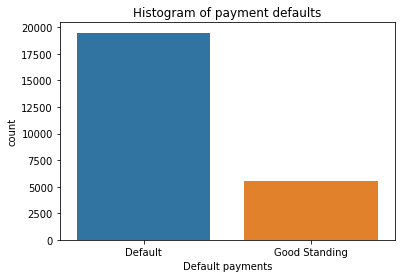

In [6]:
sns.countplot(df['default.payment.next.month'])
plt.title('Histogram of payment defaults')
plt.xticks((0,1),('Default','Good Standing'))
plt.xlabel('Default payments')

In [7]:
print( 'Percentage of default: '+ str(100*len(df[df['default.payment.next.month'] ==1]) / len(df) ))

Percentage of default: 22.056


About one in every 3.5-4 people will end up defaulting. 

C:\Users\Kelle\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


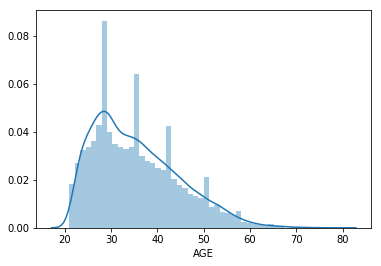

In [8]:
sns.distplot(df['AGE'])

Interesting distribution here, large concentrations around 28, 35, 43, and 52

([<matplotlib.axis.XTick at 0x25571b25588>,
 <a list of 7 Text xticklabel objects>)

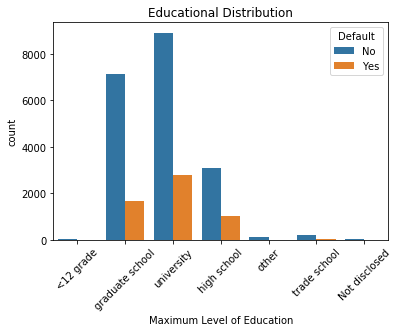

In [9]:
sns.countplot('EDUCATION',hue='default.payment.next.month',data=df)
plt.title('Educational Distribution')
plt.xlabel('Maximum Level of Education')
L = plt.legend(title='Default')
L.get_texts()[0].set_text('No')
L.get_texts()[1].set_text('Yes')
plt.xticks((0,1,2,3,4,5,6),('<12 grade','graduate school','university','high school','other','trade school','Not disclosed'),rotation=45)

Our debtors are mostly educated people. There appears to be no significance in the relationship between education and defaulting on your credit card. 

Text(0.5,1,'Relationship Status')

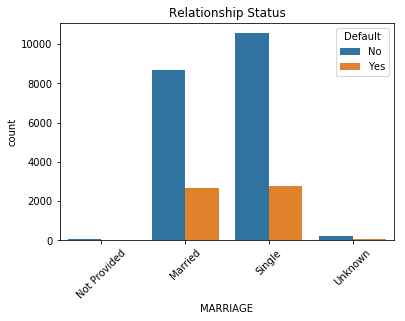

In [10]:
#mar_map = {0:'Not Provided',1:'Married',2:'Single',3:'Unknown'}
#mar_status = [mar_map[stat] for stat in df['MARRIAGE']]
sns.countplot('MARRIAGE', hue='default.payment.next.month',data=df)
plt.xticks((0,1,2,3),('Not Provided','Married','Single','Unknown'),rotation=45)
L = plt.legend(title='Default')
L.get_texts()[0].set_text('No')
L.get_texts()[1].set_text('Yes')
plt.title('Relationship Status')

A greater percentage of married people end up defaulting on their debt. One would suspect otherwise, with the additional responsibility and future planning that usually comes with marriage. But perhaps single people have fewer financial burdens, like children, and are less likely to overextend themselves financially. 

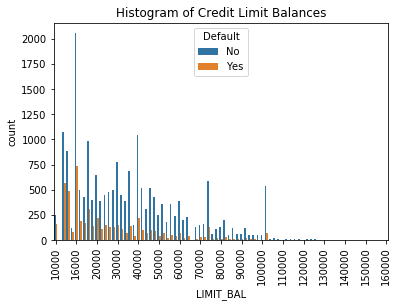

In [11]:
plot = sns.countplot(df['LIMIT_BAL'],hue = df['default.payment.next.month'])
plot.set_xticks(plot.get_xticks()[::5])
plot = plt.xticks(rotation=90)
plt.title('Histogram of Credit Limit Balances')
L = plt.legend(title='Default')
L.get_texts()[0].set_text('No')
L.get_texts()[1].set_text('Yes')

Kind of a hard figure to see but shows the relationship between a persons balance limit and their default. Generally a higher percentage of people with lower limit balances will end up defaulting. If you're a 'high risk' applicant the bank usually will only approve you for a smaller line of credit. This graph might help show why that is. 

Text(0.5,1,'Limit Balance and default distribution')

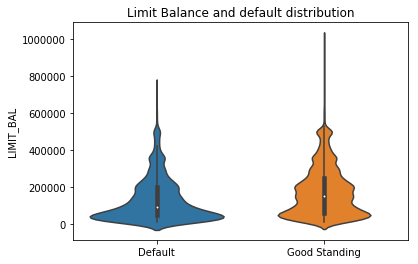

In [12]:
default_labs = {0:'Good Standing',1:'Default'}
default = [default_labs[x] for x in df['default.payment.next.month']]
sns.violinplot(x=default, y='LIMIT_BAL',data=df)
plt.title("Limit Balance and default distribution")

Perhaps not very surprisingly, people with higher limit balances are less likely to to be defaulting. The defaulters had a lower average credit limit. Likely they already had a lower credit score to begin with. 

Text(0.5,0,'')

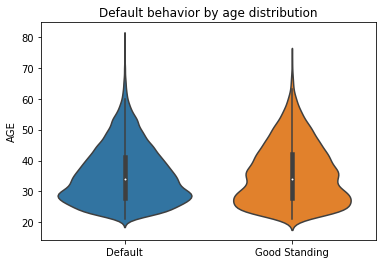

In [13]:
sns.violinplot('default.payment.next.month', y='AGE',data=df)
plt.title('Default behavior by age distribution')
plt.xticks((0,1),('Default','Good Standing'))
plt.xlabel('')

Almost no difference at all in age distributions between defaulters and not. A little surprising actually. One would imagine younger people defaulting more. 

#### Bill amounts
According to the correlation plot above, the most significant features for predicting default payments will be the BILL_AMT fields. Let's visualize a couple to see what we can infer from them

C:\Users\Kelle\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'Money Owed')

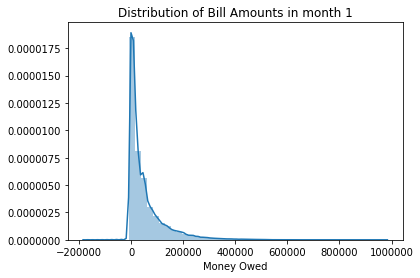

In [14]:
sns.distplot(df['BILL_AMT1'])
plt.title('Distribution of Bill Amounts in month 1')
plt.xlabel('Money Owed')

A very steep distribution toward the lowered end of money owed. Is this the general pattern this data will follow? Lets look at another month to be sure.

C:\Users\Kelle\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(-50000, 600000)

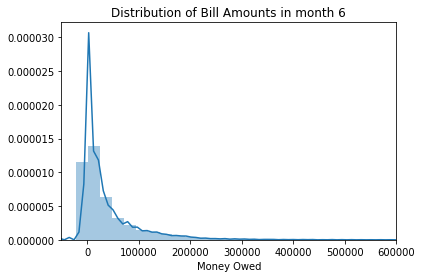

In [15]:
sns.distplot(df['BILL_AMT6'])
plt.title('Distribution of Bill Amounts in month 6')
plt.xlabel('Money Owed')
plt.xlim((-50000,600000))

Almost exactly the same. This seems to make sense. Most people won't want to have too much debt. The vast majority of people have debt below about 50,000 Taiwan New Dollars (about $1650 USD)

Text(0.5,0,'Payment Status')

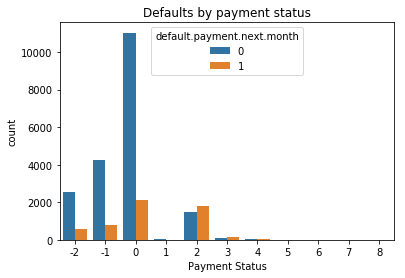

In [16]:
sns.countplot(x='PAY_2', hue = 'default.payment.next.month' , data = df)
plt.title('Defaults by payment status')
plt.xlabel('Payment Status')

Not everyone that pays on time, or is paid up in a given month is guaranteed not to default. But for the folks that are already a few months late, it looks like you're more likely to end up in default than you are to end up paying off your debt. As we saw earlier in the correlation plot, payment status will be a very strong predictor of default.

### Derived Features: 
#### To add or not to add?
Our team played with a few strategies to synthesize some more features. Some features tested were: ratio of money owed to total balance, sum off amounts owed across each month, as well as a couple others trying to get something more meaningful out of the 'limit balance', 'pay amount' and 'bill amount'. Below is some feature engineering we've done, and through this we've managed to bump our average predictions up a couple %. No revolutionary gains, but something is better than nothing. 

In [17]:
"""
Transformer class for the
    [default of credit card clients]
    (https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)
Data Set.

Usage:
    import preprocessing
    transformer = preprocessing.Transformer()
    X_train = transformer.fit_transform(df_train)
    X_test = transformer.transform(df_test)
"""
import numpy as np
import pandas as pd
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder


def _get_cols(prefix, from_idx, to_idx):
    res = []
    for i in range(from_idx, to_idx + 1):
        res.append(prefix + str(i))
    return res


class FeatureEngineer(TransformerMixin):
    """
    A Transformer for Feature Enginnering
    """
    PAY_AMTS = _get_cols('PAY_AMT', 1, 6)
    BILL_AMTS = _get_cols('BILL_AMT', 1, 6)
    PAYS = ['PAY_0'] + _get_cols('PAY_', 2, 6)

    def fit(self, dataframe):
        """
        :type dataframe pandas.DataFrame
        """
        return self

    def transform(self, dataframe):
        """
        :type dataframe pandas.DataFrame
        """
        dataframe['TOT_PAY_AMT'] = self._tot_pay_amt(dataframe)
        dataframe['TOT_BILL_AMT'] = self._tot_bill_amt(dataframe)
        dataframe['TOT_MOD'] = self._tot_month_of_delays(dataframe)
        dataframe['NUM_NO_COMSP'] = self._num_of_no_consumption(dataframe)
        dataframe['NUM_NO_DLY'] = self._num_of_no_delay(dataframe)
        return dataframe

    def _tot_pay_amt(self, dataframe):
        return dataframe[self.PAY_AMTS].sum(axis=1)

    def _tot_bill_amt(self, dataframe):
        return dataframe[self.BILL_AMTS].sum(axis=1)

    def _tot_month_of_delays(self, dataframe):
        return dataframe[self.PAYS].replace([-2, -1], 0).sum(axis=1)

    def _num_of_no_consumption(self, dataframe):
        return (dataframe[self.PAYS] == -2).sum(axis=1)

    def _num_of_no_delay(self, dataframe):
        return (dataframe[self.PAYS] == -1).sum(axis=1)


class NumFeatureSelector(TransformerMixin):
    """
    Select Numeric Features
    """
    FEATURES_ = [
        'LIMIT_BAL', 'AGE', 'TOT_PAY_AMT', 'TOT_BILL_AMT', 'TOT_MOD',
        'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
        'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4',
        'PAY_AMT5', 'PAY_AMT6'
    ]

    def __init__(self, features):
        super().__init__()
        self.features = features

    def fit(self, dataframe):
        """
        :type dataframe pandas.DataFrame
        """
        return self

    def transform(self, dataframe):
        """
        :type dataframe pandas.DataFrame
        """
        return dataframe[self.features].values


class CatFeatureSelector(TransformerMixin):
    """
    Select Categorical Features
    """
    FEATURES_ = [
        'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0',
        'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
        'NUM_NO_COMSP', 'NUM_NO_DLY'
    ]

    def __init__(self, features=None):
        super().__init__()
        self._encoder = None
        if features is None:
            features = self.CAT_FEATURES_
        self.features = features

    def fit(self, dataframe):
        """
        :type dataframe pandas.DataFrame
        """
        self._encoder = OneHotEncoder(handle_unknown='ignore')
        X = dataframe[self.features].astype('int32')
        X -= X.min().min()
        self._encoder.fit(X)
        return self

    def transform(self, dataframe):
        """
        :type dataframe pandas.DataFrame
        """
        X = dataframe[self.features].astype('int32')
        X -= X.min().min()
        return self._encoder.transform(X).toarray()

    def feature_indices(self):
        return self._encoder.feature_indices_


class Transformer(TransformerMixin):
    """
    Transform the `default of credit card clients` data
    """
    _feature_enginner = FeatureEngineer()

    def __init__(self, num_features=None, cat_features=None):
        super().__init__()
        self._need_to_fit = True
        self._pipe = None
        self.df = None
        self.cat_selector = None
        if num_features is None:
            num_features = NumFeatureSelector.FEATURES_
        if cat_features is None:
            cat_features = CatFeatureSelector.FEATURES_
        self.num_features = num_features
        self.cat_features = cat_features

    def fit(self, dataframe):
        """
        :type dataframe pandas.DataFrame
        """
        self._need_to_fit = True
        return self

    def transform(self, dataframe):
        """
        :type dataframe pandas.DataFrame
        """
        self.df = self._feature_enginner.fit_transform(dataframe)
        if self._need_to_fit:
            self._need_to_fit = False
            self.cat_selector = CatFeatureSelector(self.cat_features)
            self._pipe = Pipeline([
                ('Feature Union', FeatureUnion([
                    ('Numeric Features', NumFeatureSelector(self.num_features)),
                    ('Encoded Categorical Features', self.cat_selector),
                ])),
                ('Standard Scaler', StandardScaler()),
            ])
            return self._pipe.fit_transform(self.df)
        return self._pipe.transform(self.df)

    def feature_importances(self, importances):
        """
        :type importances numpy.ndarray
        """
        indices = self.cat_selector.feature_indices()
        col = len(self.num_features)
        cat_scores = np.zeros(len(self.cat_features))
        for i in range(1, len(indices)):
            cat_scores[i - 1] = np.sum(importances[
                (col + indices[i - 1]):(col + indices[i])
            ])
        return pd.DataFrame({
            'feature': self.num_features + self.cat_features,
            'importance': np.concatenate((
                importances[:len(self.num_features)],
                cat_scores
            ))
        }).sort_values(by=['importance'], ascending=False)

The `Transformer` class wraps the entire preprocessing logic. It contains feature engineering, selecting numeric and categorical features and transform them into indicator variables. It also provides a utility method to restore the original feature importance for the categorical features.

The new features are 

`TOT_PAY_AMT`: Total payment in the 6 months.

`TOT_BILL_AMT`: Total payment in the 6 months.

`TOT_MOD`: Number of the month of delay. 

`NUM_NO_COMSP`: Number of months without consumption (with pay value of `-2`)

`NUM_NO_DLY`: Number of months paid on time in full (with pay value of `-1`)

In [18]:
transformer = Transformer()
X = transformer.fit_transform(df)
df = transformer.df

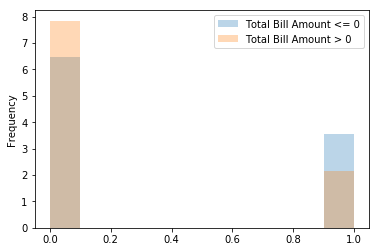

In [19]:
def get_color(x):
    return 'b' if x == 0 else 'r'

df[df['TOT_BILL_AMT'] <= 0]['default.payment.next.month'].plot(kind='hist', density=1, alpha=.3)
df[df['TOT_BILL_AMT'] > 0]['default.payment.next.month'].plot(kind='hist', density=1, alpha=.3)
plt.legend(['Total Bill Amount <= 0', 'Total Bill Amount > 0'])

We found people with negative total bill amount are more likely to default.

(array([-250000.,       0.,  250000.,  500000.,  750000., 1000000.,
        1250000., 1500000., 1750000., 2000000.]),
 <a list of 10 Text xticklabel objects>)

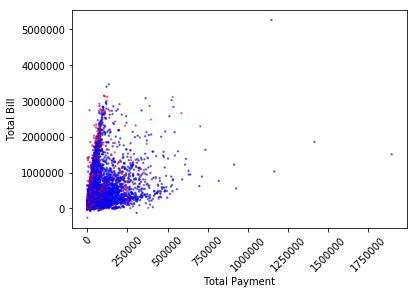

In [20]:
plt.scatter(df['TOT_PAY_AMT'], df['TOT_BILL_AMT'], s=2, alpha=0.5, c=list(map(get_color, df['default.payment.next.month'])))
plt.xlabel('Total Payment')
plt.ylabel('Total Bill')
plt.xticks(rotation=45)

It looks like the higher the ratio of total bill amount to your total payments, the more likely one is to default. This is completely logical, you're paying less than you owe, this leads to the bank closing your line of credit. 

Text(0,0.5,'Total Bill')

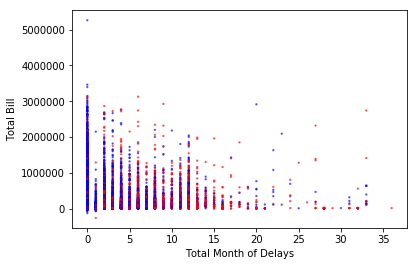

In [21]:
plt.scatter(df['TOT_MOD'], df['TOT_BILL_AMT'], s=2, alpha=0.5, c=list(map(get_color, df['default.payment.next.month'])))
plt.xlabel('Total Month of Delays')
plt.ylabel('Total Bill')

The total month of delays is the sum of the `PAY` columns excluding the negative values. This new feature indicates people with high total month of delays are more likely to default.

# Trying classifiers
We will test out a broad suite of Machine Learning algorithms, as well as a few ensemble methods to find the best means of predicting defaulters. A meta class Selector will be used to track and manage the results of the different algorithms to be sorted after all tests have been run.
In our analysis we will be focusing mainly on Accuracy, and the True Positive prediction rate, as it's most important for us to be predicting who would be defaulting, thus costing the bank/credit agency money. 

In [22]:
from sklearn.naive_bayes import GaussianNB 
from sklearn.model_selection import train_test_split

from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import pandas as pd
import os
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import  VotingClassifier,GradientBoostingClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDRegressor,LinearRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [23]:
pd.set_option('mode.chained_assignment', None)
X = transformer.fit_transform(df)
y = df['default.payment.next.month']

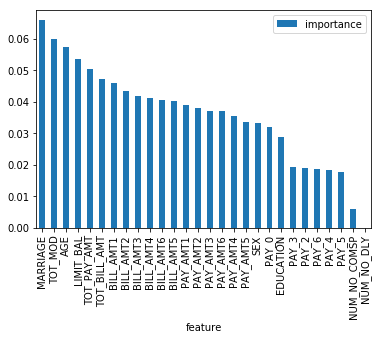

In [24]:
rand_frst = RandomForestClassifier(n_estimators=100).fit(X, y)
transformer.feature_importances(rand_frst.feature_importances_).plot(kind='bar', x='feature')

Before transforming the data we see the features that are most important to predicting default are `MARRIAGE`, `AGE` and `LIMIT_BAL`. These are all "vanilla" features. But will this remain the case after transforming the data?

In [25]:
transformer = Transformer(cat_features=[
    'SEX', 'MARRIAGE', 'PAY_0'
])
X = transformer.fit_transform(df)
y = df['default.payment.next.month']

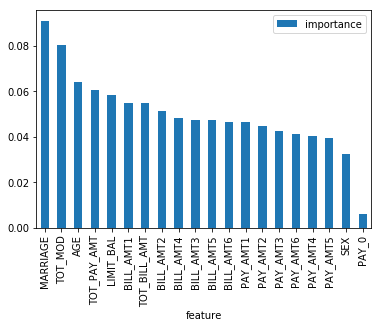

In [26]:
rand_frst = RandomForestClassifier(n_estimators=100).fit(X, y)
transformer.feature_importances(rand_frst.feature_importances_).plot(kind='bar', x='feature')

One of the derived feature `TOT_MOD` has high feature importance value according to a random forest classifier.
We remove the categorical variables with low feature importance value to reduce the dimensionality and improve the performance of the model.

### ML Specific Preprocessing

In [27]:
from sklearn.model_selection import \
        GridSearchCV, \
        learning_curve, \
        train_test_split
from sklearn.metrics import \
        accuracy_score, \
        confusion_matrix, \
        roc_curve, \
        precision_recall_fscore_support
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


class Model:
    def __init__(self, name, base_estimator, param_grid):
        """
        A model is constructed by `ModelSelection.search_and_test`
        """
        self.name = name
        self.base_estimator = base_estimator
        self.param_grid = param_grid
        self.id = None
        self.best_estimator = None
        self.best_params = None
        self.train_score = None
        self.accuracy = None
        self.precision = None
        self.recall = None
        self.fbeta = None
        self.support = None
        self.tn = None
        self.tp = None
        self.fn = None
        self.fp = None
        

    def as_df(self):
        return pd.DataFrame({
            'id': [self.id],
            'name': [self.name],
            'best_params': [self.best_params],
            'train_score': [self.train_score],
            'accuracy': [self.accuracy],
            'precision': [self.precision],
            'recall': [self.recall],
            'fbeta': [self.fbeta],
            'support': [self.support],
            'tn': [self.tn],
            'tp': [self.tp],
            'fn': [self.fn],
            'fp': [self.fp]
        }).set_index('id')


class ModelSelection:
    TARGET_ = 'default.payment.next.month'

    def __init__(self, df, transformer, test_size, max_parallelism=None):
        df_train, df_test = train_test_split(df, test_size=test_size)
        self.X_train = transformer.fit_transform(df_train)
        self.y_train = df_train[self.TARGET_]
        self.X_test = transformer.transform(df_test)
        self.y_test = df_test[self.TARGET_]
        self.models = []
        self.max_parallelism = max_parallelism

    def search_and_test(self, name, base_estimator, param_grid, cv=5, verbose=1):
        """
        Perform Grid Search on the param grid & Test the best model

        Parameters
        ----------
        name: string

        base_estimator: sklearn.estimator

        param_grid: dict
            param_grid for GridSearch

        cv: int, cross-validation generator or an iterable, optional
        """
        model = Model(name, base_estimator, param_grid)
        gs = GridSearchCV(base_estimator, param_grid=param_grid,
                          cv=cv, n_jobs=self.max_parallelism, verbose=verbose)
        if verbose != 0:
            print('Starting Grid Search')
        gs.fit(self.X_train, self.y_train)
        model.best_params = gs.best_params_
        model.best_estimator = gs.best_estimator_
        model.train_score = gs.best_score_
        if verbose != 0:
            print('Fitting the best estimator')
        model.best_estimator.fit(self.X_train, self.y_train)
        if verbose != 0:
            print('Testing the best estimator')
        y_pred = model.best_estimator.predict(self.X_test)
        model.accuracy = accuracy_score(self.y_test, y_pred)
        cm = confusion_matrix(self.y_test, y_pred)
        model.tn, model.fp, model.fn, model.tp = cm.ravel()
        scores = precision_recall_fscore_support(
            self.y_test, y_pred, average='binary'
        )
        model.precision, model.recall, model.fbeta, model.support = scores
        model.id = len(self.models)
        self.models.append(model)
        return model

    def plot_confusion_matrix(self, ax, model, normalize=True):
        """
        Plots the confusion matrix for the model

        Parameters
        ----------
        model : Model
            A model should be contructed by `search_and_test` method
        """
        df_cm = pd.DataFrame({
            0: [model.tn, model.fn],
            1: [model.fp, model.tp]
        })
        if normalize:
            total = model.tn + model.tp + model.fn + model.fp
            df_cm = df_cm.astype('float') / total
        sns.heatmap(df_cm, annot=True, ax=ax)
        ax.set_title('Confusion Matrix\n{}\n{}'.format(
            model.name, model.best_params
        ))
        ax.set_ylabel("True")
        ax.set_xlabel("Prediction")
        return plt

    def plot_learning_curve(self, ax, model, ylim=None, cv=None,
                            train_sizes=np.linspace(.5, 1.0, 5)):
        """
        Generate a simple plot of the test and training learning curve.
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

        Parameters
        ----------
        model : Model
            A model should be contructed by `search_and_test` method

        ylim : tuple, shape (ymin, ymax), optional
            Defines minimum and maximum yvalues plotted.

        cv : int, cross-validation generator or an iterable, optional

        train_sizes : array-like, shape (n_ticks,), dtype float or int
            Relative or absolute numbers of training examples that will be used to
            generate the learning curve. If the dtype is float, it is regarded as a
            fraction of the maximum size of the training set (that is determined
            by the selected validation method), i.e. it has to be within (0, 1].
            Otherwise it is interpreted as absolute sizes of the training sets.
        """
        ax.set_title("{}\n{}".format(model.name, model.best_params))
        if ylim is not None:
            ax.set_ylim(*ylim)
        ax.set_xlabel("Training examples")
        ax.set_ylabel("Score")
        train_sizes, train_scores, test_scores = learning_curve(
            model.best_estimator, self.X_train, self.y_train, cv=cv,
            n_jobs=self.max_parallelism, train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        ax.grid()

        ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
        ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
        ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
        ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")

        ax.legend(loc="best")
        return plt

    def get_predictions(self, model):
        '''
        Get the predictions from a model given multiple parameters to test
    
        Parameters
        ----------
        model: Used for training to get predictions
        '''
        flat = [[(k, v) for v in vs] for k, vs in model.param_grid.items()]
        parameters_flat = [dict(items) for items in product(*flat)]
   
        predictions = []
        for i in parameters_flat:
            model.base_estimator.set_params(**i)
            model.base_estimator.fit(self.X_train, self.y_train)
            predict = model.base_estimator.predict(self.X_test)
            predictions.append(predict)
        return predictions, parameters_flat
    
    def plot_PR(self, ax, model, predictions, parameters_flat):
        '''
        Generates a Precision Recall plot for our model given a set of parameters to search through
        
        Parameters
        ----------
        model:Used for getting the name, and best aprameters for title
        
        predictions : An array of predictions from a model given multiple parameters to test
        
        parameters_flat: a set of all the possible parameters for testing.
        '''
        model_name = list(range(0,400))
        count = 0
        a = np.empty((1,4))
        for i in predictions:
            precision, recall, f, beta = precision_recall_fscore_support(self.y_test, i, average='binary')
            a = np.append(a, np.array([[model_name[count], parameters_flat[count], precision, recall]]),axis = 0)
            plt.scatter(precision, recall)
            count = count + 1
        ax.set_xlabel("precision")
        ax.set_ylabel("recall")
        ax.set_title('Precision Recall\n{}'.format(model.name))

        legend = pd.DataFrame(a[1:])
        legend.columns = ['model#', 'parameters','precision','recall']
        #return(legend)
    
    def plot_ROC(self, ax, model, predictions, parameters_flat):
        """
        Generates a ROC scatter plot for our model given a set of parameters to search through

        Parameters
        ----------
        model:Used for getting the name, and best aprameters for title
        
        predictions : An array of predictions from a model given multiple parameters to test
        
        parameters_flat: a set of all the possible parameters for testing.
        """
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        model_name = list(range(0,600))
        a = np.empty((1,4))

        count = 0
        for i in predictions: 
            fpr, tpr, thresholds = roc_curve(self.y_test, i)      
            ax.scatter(fpr, tpr)
            a = np.append(a, np.array([[model_name[count], parameters_flat[count], fpr, tpr]]),axis = 0)
            count = count + 1
        
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC\n{}'.format(model.name))
        
        legend = pd.DataFrame(a[1:])
        legend.columns = ['model#', 'parameters','fpr','tpr']
        #return(legend)
    
    def plot_ROC_PR(self, axes, model):
        '''
        Plot the Precision Recall and Receiver Operating curves
    
        Parameters
        ----------
        model: stores the values of parameters and predictions
            
        '''    
        predictions, parameters = self.get_predictions(model)
        legend1 = self.plot_ROC(axes[0], model, predictions, parameters)
        legend2 = self.plot_PR(axes[1], model, predictions, parameters)
        legends = [legend1,legend2]
        #return legends 

    def plot(self, model, verbose=1):
        """
        Generates all the plots we have for the model

        Parameters
        ----------
        model : Model
            A model should be contructed by `search_and_test` method
        """
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
        plt.subplots_adjust(top=1.05, hspace=0.3)
        if verbose != 0:
            print('Plotting the Confusion Matrix')
        self.plot_confusion_matrix(axes[0][0], model)
        if verbose != 0:
            print('Plotting the Learning Curve', )
        self.plot_learning_curve(axes[1][0], model)
        if verbose != 0:
            print('Plotting the Precision vs Recall')
        self.plot_ROC_PR((axes[0][1], axes[1][1]), model)


    def as_df(self):
        """
        Output the models as a pandas dataframe
        """
        return pd.concat(
            [model.as_df() for model in self.models]
        ).sort_values(by=['accuracy'], ascending=False)

In [28]:
selector = ModelSelection(df, transformer, test_size=0.3, max_parallelism=8)

## Gradient Boosting Classifier

Starting Grid Search
Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   14.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   34.3s
[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed:  1.1min finished


Fitting the best estimator
Testing the best estimator
Plotting the Confusion Matrix
Plotting the Learning Curve
Plotting the Precision vs Recall


,name,best_params,train_score,accuracy,precision,recall,fbeta,support,tn,tp,fn,fp
id,,,,,,,,,,,,
0,Gradient Boosting Classifier,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.817486,0.822267,0.638702,0.361164,0.461414,None,5596,571,1010,323


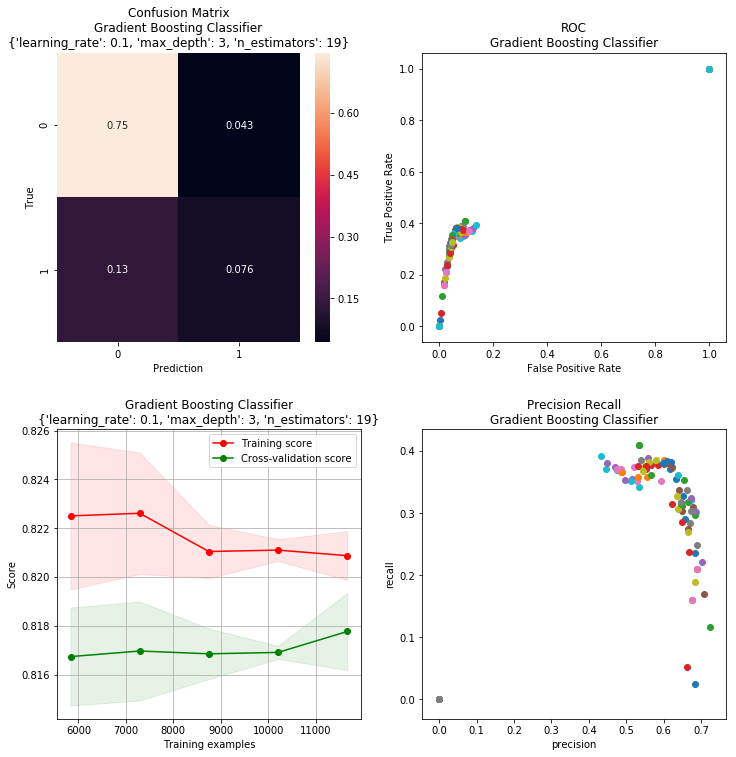

In [29]:
gb = selector.search_and_test(
    'Gradient Boosting Classifier',
    GradientBoostingClassifier(),
    {
        'n_estimators': range(1, 20, 2),
        'max_depth': range(1, 10, 2),
        'learning_rate': [0.01, 0.1, 1]
    }
)
selector.plot(gb)
gb.as_df()

Here we can see that gradient boosting should be a good model to choose for our final voting classifier. We can see that its TP rate is good given the data set. We can also see that this classifier will perform better given a larger dataset. Looking at the ROC curve, we can see that the TP rate plateaus around 0.4 The precision-recall seems fairly good given it has a high precision given a relatively low recall. All of these characteristics make this a good candidate for our voting classifier.

## Stochastic Gradient Desecent

Starting Grid Search
Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done 530 tasks      | elapsed:    8.5s
[Parallel(n_jobs=8)]: Done 900 out of 900 | elapsed:   11.0s finished


Fitting the best estimator
Testing the best estimator
Plotting the Confusion Matrix
Plotting the Learning Curve
Plotting the Precision vs Recall


,name,best_params,train_score,accuracy,precision,recall,fbeta,support,tn,tp,fn,fp
id,,,,,,,,,,,,
1,Stochastic Gradient Desecent Classifier,"{'alpha': 0.1, 'class_weight': {0: 1, 1: 1.375...",0.817486,0.8216,0.626431,0.380772,0.473643,None,5560,602,979,359


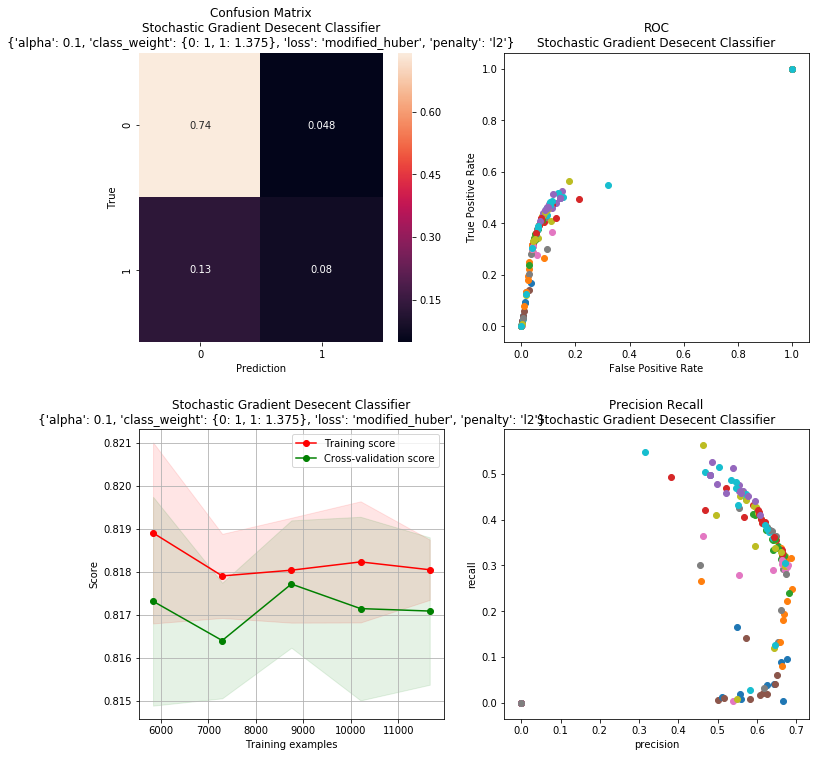

In [30]:
sgd = selector.search_and_test(
    'Stochastic Gradient Descent Classifier',
    SGDClassifier(),
    {
        'alpha': [0.001, 0.01, 0.1, 1],
        'loss': ['hinge', 'modified_huber', 'log'],
        'penalty': ['l2', 'l1', 'elasticnet'],
        'class_weight': [
            {0: 1, 1: i} for i in np.linspace(0.25, 2.5, 5)
        ]
    }
)
selector.plot(sgd)
sgd.as_df()

Stochastic gradient descent performed better than our previous classifier in terms of TP to FP rate. Although it performed well we can see that this model will not improve given more data because it suffers from high bias. Looking at the ROC plot we can see that the TP rate increases until it develops an elbow. This is where the model is predicting the best estimator. We can also see from our precision-recall that our model does fairly well keeping high precision with a relatively low recall.

## Support Vector Machine

Starting Grid Search
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:  5.9min finished


Fitting the best estimator
Testing the best estimator
Plotting the Confusion Matrix
Plotting the Learning Curve
Plotting the Precision vs Recall


,name,best_params,train_score,accuracy,precision,recall,fbeta,support,tn,tp,fn,fp
id,,,,,,,,,,,,
2,Support Vector Machine Classifier,"{'C': 1, 'class_weight': {0: 1, 1: 1.375}, 'ke...",0.816686,0.8216,0.63337,0.364959,0.463082,None,5585,577,1004,334


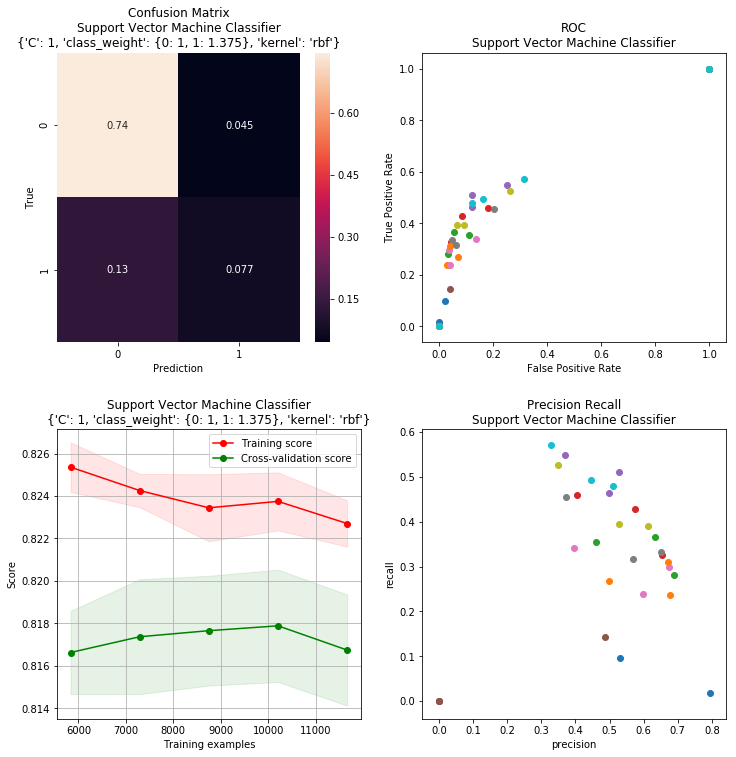

In [31]:
svc = selector.search_and_test(
    'Support Vector Machine Classifier',
    svm.SVC(),
    {
        'kernel': ['rbf', 'sigmoid'],
        'C': [0.01, 0.1, 1],
        'class_weight': [
            {0: 1, 1: i} for i in np.linspace(0.25, 2.5, 5)
        ]
    }
)
selector.plot(svc)
svc.as_df()

Support vector machine is our best performing model so far. It has the highest TP rate of all the models so far. We can see that this model is not converging in the learning curve meaning more data will not help us. Looking at the ROC, we can see that we are achieving relatively similar TP rates with an increased FP rate compared to previous models. Our Precision-recall curve seems to be more dispersed, but we are still focused on the highest precision and lowest recall picking the model around .67 precision, 0.37 recall. This model has a high TP classification making it a good candidate for our final voting classifier.

## K-Nearest Neighbors

Starting Grid Search
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:  1.2min finished


Fitting the best estimator
Testing the best estimator
Plotting the Confusion Matrix
Plotting the Learning Curve
Plotting the Precision vs Recall


,name,best_params,train_score,accuracy,precision,recall,fbeta,support,tn,tp,fn,fp
id,,,,,,,,,,,,
3,K-Nearest Neighbors Classifier,{'n_neighbors': 9},0.805943,0.8084,0.572289,0.360531,0.442375,None,5493,570,1011,426


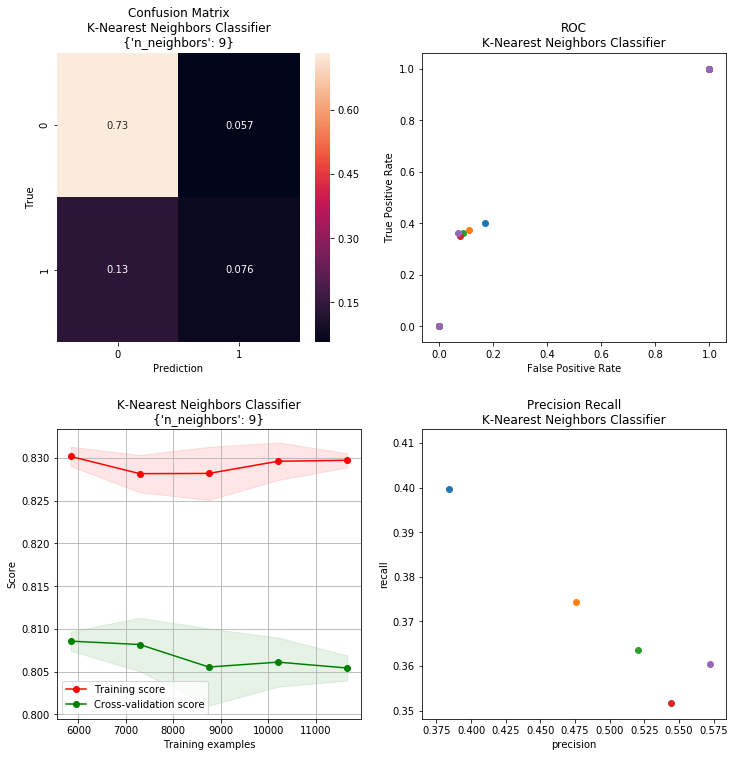

In [32]:
knn = selector.search_and_test(
    'K-Nearest Neighbors Classifier',
    KNeighborsClassifier(),
    {
        'n_neighbors': range(1, 11, 2)
    }
)
selector.plot(knn)
knn.as_df()

This model is performing relatively well. We can see this model has high variance in it but from the ROC we can see the TP rate is good enough to possibly be included in our final model. From looking at our Precision-Recall curve we can see we have chosen the model with a precision of around .6 and a recall of about .37 which is similar to our SVM.

## Decision Tree

Starting Grid Search
Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    7.7s finished


Fitting the best estimator
Testing the best estimator
Plotting the Confusion Matrix
Plotting the Learning Curve
Plotting the Precision vs Recall


,name,best_params,train_score,accuracy,precision,recall,fbeta,support,tn,tp,fn,fp
id,,,,,,,,,,,,
4,Decision Tree Classifier,"{'class_weight': {0: 1, 1: 1.125}, 'max_depth'...",0.815714,0.818,0.598361,0.41556,0.490482,None,5478,657,924,441


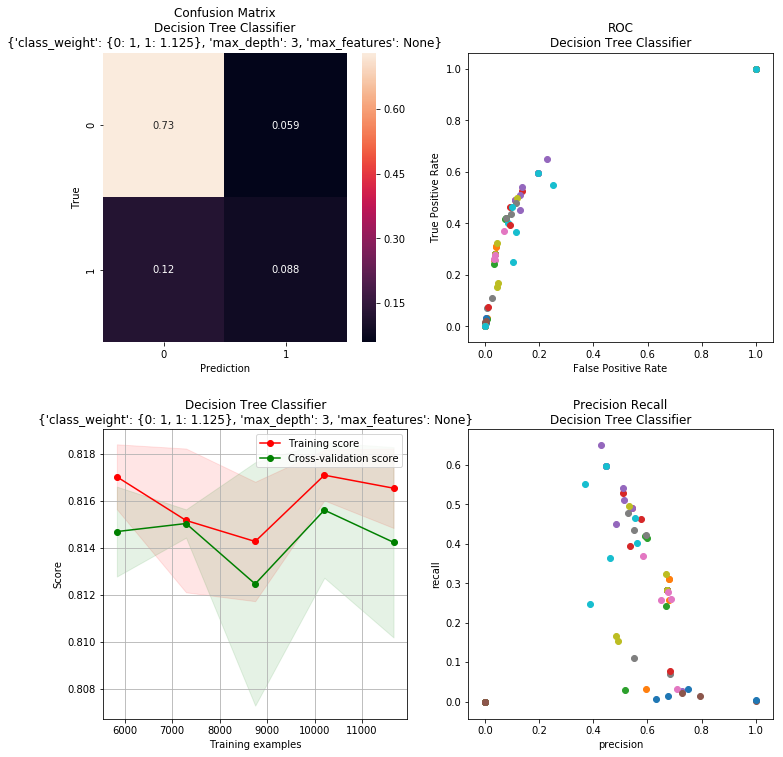

In [33]:
dt = selector.search_and_test(
    'Decision Tree Classifier',
    DecisionTreeClassifier(),
    {
        'max_depth': range(1, 5),
        'max_features': [None, 3, 6, 18],
        'class_weight': [
            {0: 1, 1: i} for i in np.linspace(0.25, 2.0, 5)
        ]
    }
)
selector.plot(dt)
dt.as_df()

This model has the best TP classification rate of all. We can see in the ROC graph that the TP rate has an elbow around 0.6 TP rate which is close to the model we chose. along with this we can see that the Precision and Recall are fairly high at the bottom right portion of the graph. This model looks good except for the learning curve. Given that the Training and CV scores are close to each other we know the model has High Bias. Although it suffers from this we will use this model because of its high TP rate

# Random Forest

Starting Grid Search
Fitting 5 folds for each of 275 candidates, totalling 1375 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   21.5s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   48.4s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 1375 out of 1375 | elapsed:  2.6min finished


Fitting the best estimator
Testing the best estimator
Plotting the Confusion Matrix
Plotting the Learning Curve
Plotting the Precision vs Recall


,name,best_params,train_score,accuracy,precision,recall,fbeta,support,tn,tp,fn,fp
id,,,,,,,,,,,,
5,Random Forest Classifier,"{'class_weight': {0: 1, 1: 1.375}, 'max_depth'...",0.819029,0.818667,0.606352,0.398482,0.480916,None,5510,630,951,409


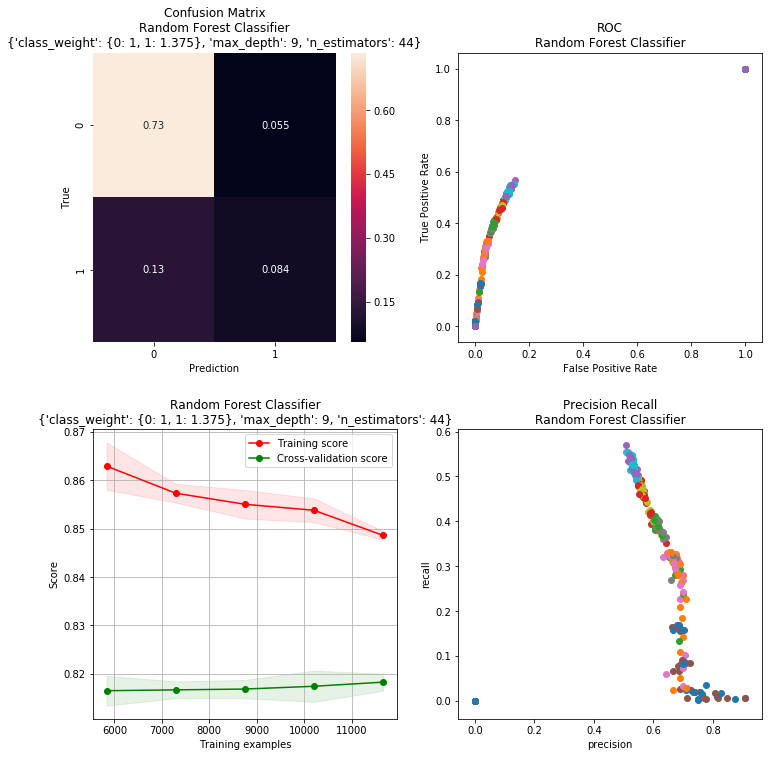

In [34]:
rf = selector.search_and_test(
    "Random Forest Classifier",
    RandomForestClassifier(),
    {
        'n_estimators': range(35, 46),
        'max_depth': range(3, 13, 2),
        'class_weight': [
            {0: 1, 1: i} for i in np.linspace(0.25, 2.5, 5)
        ]
    }
)
selector.plot(rf)
rf.as_df()

This model is performing fairly well. The TP rate is about average. Looking at our ROC plot, we can see that the elbow occurs around 0.4 TP rate. We can get a higher TP of 0.6, but the cost of TP vs FP becomes too high. From our precision-recall we can see our model is performing well having a relatively high precision with a low recall. This model may be a good candidate for our final model given its high TP rate.

## ADA-Boost

Starting Grid Search
Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   32.8s
[Parallel(n_jobs=8)]: Done 135 out of 135 | elapsed:  2.6min finished


Fitting the best estimator
Testing the best estimator
Plotting the Confusion Matrix
Plotting the Learning Curve
Plotting the Precision vs Recall


,name,best_params,train_score,accuracy,precision,recall,fbeta,support,tn,tp,fn,fp
id,,,,,,,,,,,,
6,ADA Boost Classifier,"{'learning_rate': 0.01, 'n_estimators': 90}",0.816571,0.821467,0.617704,0.401645,0.486777,None,5526,635,946,393


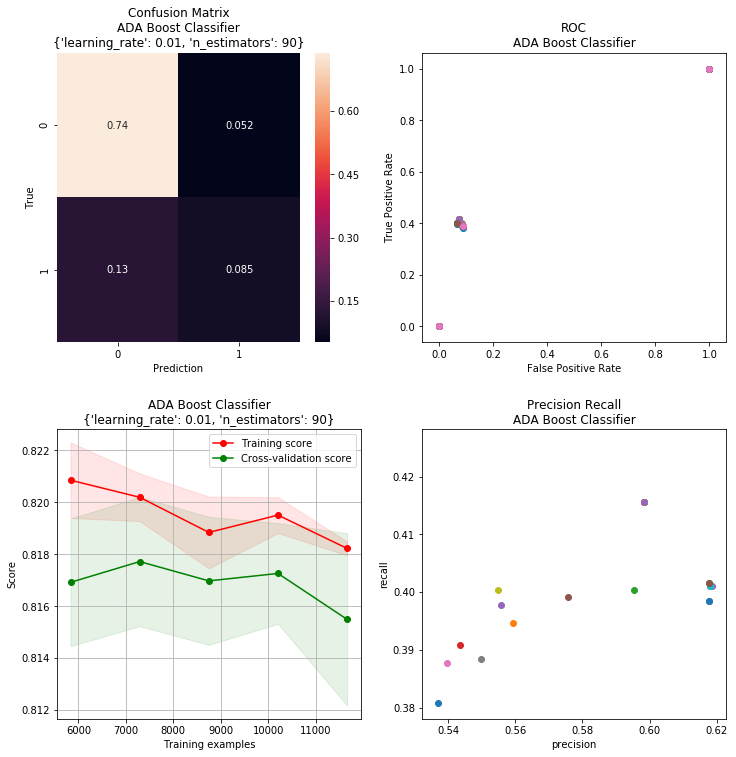

In [35]:
ada = selector.search_and_test(
    "ADA Boost Classifier",
    AdaBoostClassifier(dt.best_estimator),
    {
        'n_estimators': range(10, 100, 10),
        'learning_rate': [0.001, 0.01, 1]
    }
)
selector.plot(ada)
ada.as_df()

This is another well-performing model. We can see that its accuracy is high along with its TP total. From examining our ROC plot, we can see the model has a high TP rate with a relatively low range of FP values given how many TP's it is classifying. When looking at our Precision-Recall curve, we can see that out precision is ok with an ok recall. This precision-recall value is likely ok due to the large amount of positive classifications being done. From the learning curve, we can see this model has high bias meaning it will not perform better given more data

# Selected Model

In [36]:
models_sorted_tp = selector.as_df().sort_values(by=['tp'], ascending=False)
estimators = []
for i in range(0,4):
    estimators.append((
        selector.models[models_sorted_tp.index[i]].name, 
        selector.models[models_sorted_tp.index[i]].best_estimator
    ))
selector.as_df().sort_values(by=['tp'], ascending = False)    

,name,best_params,train_score,accuracy,precision,recall,fbeta,support,tn,tp,fn,fp
id,,,,,,,,,,,,
4,Decision Tree Classifier,"{'class_weight': {0: 1, 1: 1.125}, 'max_depth'...",0.815714,0.818000,0.598361,0.415560,0.490482,None,5478,657,924,441
6,ADA Boost Classifier,"{'learning_rate': 0.01, 'n_estimators': 90}",0.816571,0.821467,0.617704,0.401645,0.486777,None,5526,635,946,393
5,Random Forest Classifier,"{'class_weight': {0: 1, 1: 1.375}, 'max_depth'...",0.819029,0.818667,0.606352,0.398482,0.480916,None,5510,630,951,409
1,Stochastic Gradient Desecent Classifier,"{'alpha': 0.1, 'class_weight': {0: 1, 1: 1.375...",0.817486,0.821600,0.626431,0.380772,0.473643,None,5560,602,979,359
2,Support Vector Machine Classifier,"{'C': 1, 'class_weight': {0: 1, 1: 1.375}, 'ke...",0.816686,0.821600,0.633370,0.364959,0.463082,None,5585,577,1004,334
0,Gradient Boosting Classifier,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.817486,0.822267,0.638702,0.361164,0.461414,None,5596,571,1010,323
3,K-Nearest Neighbors Classifier,{'n_neighbors': 9},0.805943,0.808400,0.572289,0.360531,0.442375,None,5493,570,1011,426


Next, we created a voting classifier using the top 4 models sorted by TP rate. The classifier is weighted more heavily towards the first classifier in the voter. This classifier will out beat other classifiers 90% of the time with SVM outperforming it the other 10% of the time.

In [37]:
voting = selector.search_and_test(
    'Voting Classifier',
    VotingClassifier(estimators=estimators),{
        'voting': ['hard'], 
        'weights': [[2, 1, 1, 1],
                    [2, 2, 1, 1],
                    [1, 2, 1, 1],
                    [1, 2, 2, 1],
                    [1, 1, 1, 2]]
    }
)
selector.as_df()

Starting Grid Search
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:  1.2min finished


Fitting the best estimator
Testing the best estimator


,name,best_params,train_score,accuracy,precision,recall,fbeta,support,tn,tp,fn,fp
id,,,,,,,,,,,,
0,Gradient Boosting Classifier,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.817486,0.822267,0.638702,0.361164,0.461414,None,5596,571,1010,323
7,Voting Classifier,"{'voting': 'hard', 'weights': [1, 2, 2, 1]}",0.818743,0.822000,0.629747,0.377609,0.472123,None,5568,597,984,351
1,Stochastic Gradient Desecent Classifier,"{'alpha': 0.1, 'class_weight': {0: 1, 1: 1.375...",0.817486,0.821600,0.626431,0.380772,0.473643,None,5560,602,979,359
2,Support Vector Machine Classifier,"{'C': 1, 'class_weight': {0: 1, 1: 1.375}, 'ke...",0.816686,0.821600,0.633370,0.364959,0.463082,None,5585,577,1004,334
6,ADA Boost Classifier,"{'learning_rate': 0.01, 'n_estimators': 90}",0.816571,0.821467,0.617704,0.401645,0.486777,None,5526,635,946,393
5,Random Forest Classifier,"{'class_weight': {0: 1, 1: 1.375}, 'max_depth'...",0.819029,0.818667,0.606352,0.398482,0.480916,None,5510,630,951,409
4,Decision Tree Classifier,"{'class_weight': {0: 1, 1: 1.125}, 'max_depth'...",0.815714,0.818000,0.598361,0.415560,0.490482,None,5478,657,924,441
3,K-Nearest Neighbors Classifier,{'n_neighbors': 9},0.805943,0.808400,0.572289,0.360531,0.442375,None,5493,570,1011,426


Next we created a voting classifier using the top 4 models sorted by TP rate. The classifier is weighter more heavily towards the first classifier in the voter. This classifier will outbeat other classifiers 90% of the time with SVM out performing it the other 10% of the time. 

## Analysis of training and predictions
If sorting by `True Positive` rate, the `Stochastic Gradient Descent Classifier` has the best performance.
If sorting by pure `Accuracy`, our `Voting Classifier` has the best performance.
The range of `Accuracy` was relatively tight, with a minimum of about 80% with `KNearest Neighbors` and a maximum just shy of 82% with the `Voting Classifier`. 
There was  greater disparity of `True Positive` rates, with `Stochastic Gradient Descent Classifier` getting the maximum score of 623, and the `Decision Tree Classifier` getting a minimum of 456. 


## Best Predictor:

In [41]:
models = selector.as_df()

''' 
Take the row index of the predictor with the
highest acccuracy from the models dataframe
''' 
top_model_id = models.index[0]

# Estimator is already instantiated with best hyperparameters
selector.models[top_model_id].best_estimator

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=19,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

### Best Parameters

In [42]:
selector.models[top_model_id].best_params

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 19}

In [43]:
'''
Now we'll assign the best parameters from our tests
to a new model to be inserted into our bundling function below.
'''
best_estimator = GradientBoostingClassifier(
                            learning_rate = 0.1,
                            max_depth = 3,
                            n_estimators = 19
                            )

# Please Enter New Test Data Here

In [ ]:
''' Please enter file string for test data to be used in grading report. '''
test_data_file_string = ''  # Enter file string of new test data

train_data_file_string = '' # Please enter file path of training data set

def bundle_predict(estimator, train_dat, test_dat):
    '''
    Takes in new training and test data, transforms, then trains
    and predicts on new training and test sets.

    Parameters
    ---------------
    estimator - best estimator from selector class, parameters tuned.

    train_dat - pandas dataframe (the 25K rows of data collected from:
        https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients).

    test_dat - pandas dataframe ( the new data provided by the grader
        of the project, Dr. Bruns).
    
    '''
    TARGET_ = 'default.payment.next.month'
    y_train_dat = train_dat[TARGET]
    # Fit and transform data
    train_dat = transformer.fit_transform(train_dat)
    # Transform test data with fit from training data
    test_dat = transformer.transform(test_dat)
    estimator.fit(train_dat, y_train_dat)
    return estimator.predict(test_dat)

# Read in ALL data previously used to be used ONLY as training data
train_dat = pd.read_csv(train_data_file_string, sep = ',')

# Read in new test data
test_dat = pd.read_csv(test_data_file_string, sep = ',') 

test_predictions = bundle_predict(best_estimator, train_dat, test_dat)

# Conclusion
   Our best prediction accuracy was around 82-83%, our lowest measured prediction accuracy was about 80%. This is not a particularly large spread, especially considering the disparity in the time it takes for some models to train with the Grid Search to find the best hyper-parameters.

   From our first week check-in period to the final due date of our report we streamlined the training and prediction process very well, but despite the feature engineering, and hyper parameter tuning we didn't see a particularly significant change in predictive power of our models. With the theoretical maximum being unknown, it's hard to determine where the ceiling would be in terms of predictive power of a Machine Learning Algorithm given this data set. Some outside research has shown some data scientists able to predict defaults with an accuracy of near 88%, but this involved the use of layers of Neural Networks, which is unfortunately beyond the scope of this project, and at least beyond my personal abilities in Machine Learning, not necessarily beyond the scope of everyone's abilities in our group. But time was also a slight limitation in this project as well. Given enough time, accuracy could likely be improved, but there is always a point of diminishing returns. Additionally, the concept of intelligibility must be considered in a project like this, if some black-box algorithm can predict someone's likelihood to default higher than ours, but the variables rely on the person's performance once they're already granted credit, it does little good to the bank or credit agency, other than giving them advanced warning, allowing them to revoke a person's credit sooner, rather than later.
   
  If we were to make recommendation to a crediting agency about the granting of credit, with respect to the debtors likelihood to default, it would be:
  1. Consider the applicants marital status. Married people seem to default more often.
  2. Consider the age of the applicant. Younger people are at higher risk of defaulting.
  3. Establish a lower limit balance for applicants that would be considered risky. 
  4. Once granted credit, pay special attention to the ratio of payments to the amount owed on their balance. There will be some threshold were it's very unlikely that they will be able to pay you back.
  5. Limit the number of months a debtor may be late on their payments to 3, like most credit agencies. At this point it's more likely that the person will default than pay you back. At this point you're only giving more money away. 